Community Structure Exploration in the Karate Club Network

DSC212 – Graph Theory Coursework

Overview

This notebook investigates how communities emerge within the classic Zachary’s Karate Club dataset using spectral methods. The analysis relies on identifying partitions via the principal eigenvector of the modularity matrix, and then recursively subdividing the network to detect additional groups. Along the way, we also observe how centrality measures for nodes change as more refined communities are uncovered.

Reference Framework

The ideas behind the modularity score, the construction of the modularity matrix, and the spectral approach for dividing networks stem from:

Newman, M. E. J. (2006). “Modularity and community structure in networks.” Proceedings of the National Academy of Sciences, 103(23), 8577–8582.

In [1]:
# Import required libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.linalg import eigh
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

1.  Access the Karate Club Dataset


    The well-known Karate Club network is built into NetworkX. It models 34 individuals from the club and the 78 social connections recorded between them.

In [2]:
# Load the Karate Club graph
G = nx.karate_club_graph()
n = G.number_of_nodes()
m = G.number_of_edges()

print(f"Karate Club Graph: {n} nodes, {m} edges")
print(f"\nNodes represent club members, edges represent social interactions.")
print(f"The club split into two factions led by Mr. Hi (node 0) and the President (node 33).")

Karate Club Graph: 34 nodes, 78 edges

Nodes represent club members, edges represent social interactions.
The club split into two factions led by Mr. Hi (node 0) and the President (node 33).


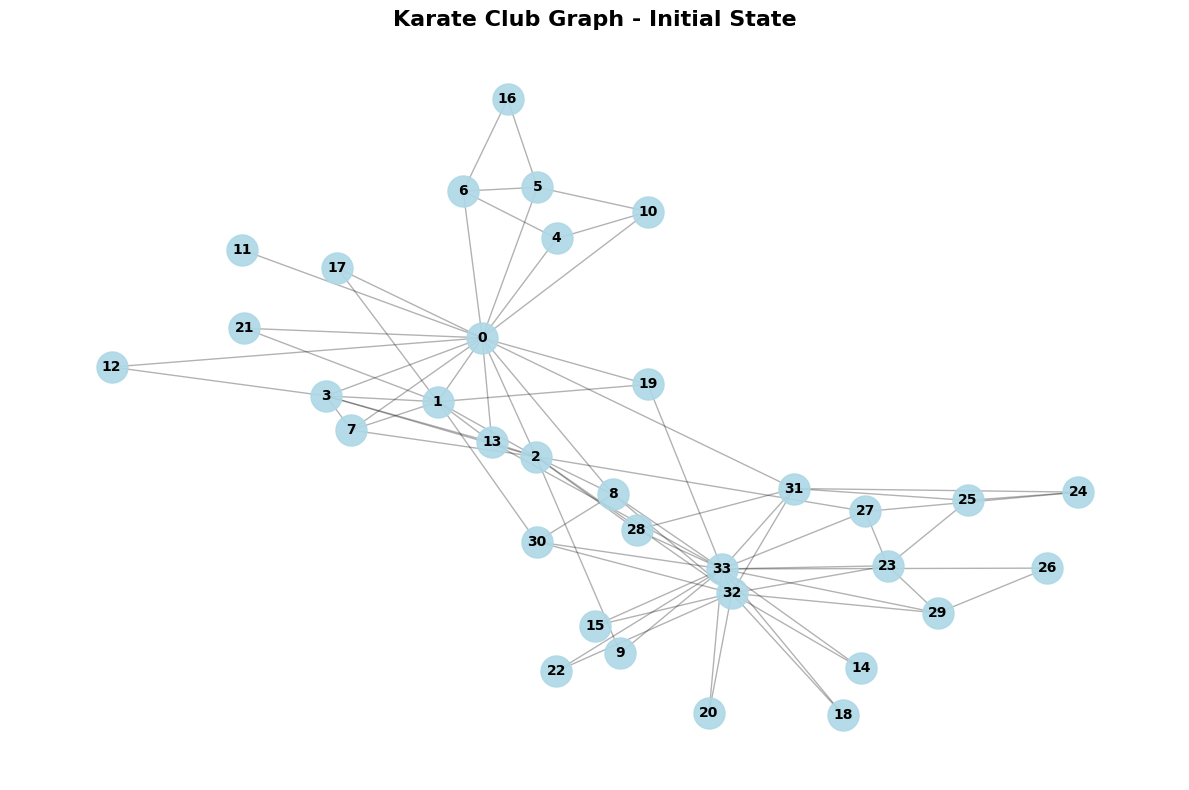

In [3]:
# Visualize the original graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistency across iterations
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
plt.title('Karate Club Graph - Initial State', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Constructing the Modularity Matrix

To perform spectral modularity analysis, we first build the modularity matrix defined by:

$$
B = A - \frac{k k^\top}{2m}
$$

where:

- $A$ is the adjacency matrix  
- $k$ is the vector of node degrees  
- $m$ is the total number of edges  

This compares observed edges with the expected number of edges in a null model preserving the degree sequence.


In [4]:
def compute_modularity_matrix(G, nodes=None):
    """
    Compute the modularity matrix B for a graph or subgraph.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    nodes : list or None
        If provided, compute B for the subgraph induced by these nodes.
        Otherwise, compute for the entire graph.

    Returns:
    --------
    B : numpy.ndarray
        The modularity matrix
    node_list : list
        The ordered list of nodes corresponding to matrix rows/columns
    """
    # Use full graph if no nodes specified
    if nodes is None:
        nodes = list(G.nodes())

    # Create subgraph if needed
    if len(nodes) < G.number_of_nodes():
        subG = G.subgraph(nodes)
    else:
        subG = G

    # Get adjacency matrix and degree vector
    node_list = list(nodes)
    A = nx.to_numpy_array(subG, nodelist=node_list)
    k = np.array([subG.degree(node) for node in node_list])

    # Total edges in the FULL graph (important: use original graph's m)
    m = G.number_of_edges()

    # Compute modularity matrix: B = A - (k * k^T) / (2m)
    B = A - np.outer(k, k) / (2 * m)

    return B, node_list

3. Spectral Division of the Network

To separate a community using spectral modularity:

1 . Compute the top eigenvector u₁ of the modularity matrix B.

2 . Verify whether the corresponding eigenvalue λ₁ is greater than zero.

3 . When λ₁ > 0, assign nodes to two groups depending on whether their entry in u₁
is positive or negative.

4 . If the eigenvalue is non-positive, the community is considered indivisible.


In [6]:
def spectral_bipartition(G, nodes):
    """
    Attempt to split a community using spectral bipartition.

    Parameters:
    -----------
    G : networkx.Graph
        The full graph
    nodes : list
        The nodes in the community to split

    Returns:
    --------
    split : bool
        True if split is beneficial (lambda_1 > 0), False otherwise
    community1 : list
        Nodes assigned to first community (if split is True)
    community2 : list
        Nodes assigned to second community (if split is True)
    lambda_1 : float
        The leading eigenvalue
    """
    # Compute modularity matrix for this community
    B, node_list = compute_modularity_matrix(G, nodes)

    # Compute eigenvalues and eigenvectors
    # Use eigh for symmetric matrices (more efficient and stable)
    eigenvalues, eigenvectors = eigh(B)

    # Get leading eigenvalue and eigenvector (largest eigenvalue)
    idx = np.argmax(eigenvalues)
    lambda_1 = eigenvalues[idx]
    u_1 = eigenvectors[:, idx]

    # Check stopping criterion
    if lambda_1 <= 1e-10:  # Use small tolerance for numerical stability
        return False, None, None, lambda_1

    # Split by sign of eigenvector entries
    community1 = [node_list[i] for i in range(len(node_list)) if u_1[i] > 0]
    community2 = [node_list[i] for i in range(len(node_list)) if u_1[i] <= 0]

    # Ensure both communities are non-empty
    if len(community1) == 0 or len(community2) == 0:
        return False, None, None, lambda_1

    return True, community1, community2, lambda_1

4 . Implement Recursive Bisection

  Use spectral bipartition repeatedly to split the graph into smaller communities until no further positive eigenvalues remain.

In [7]:
def recursive_bisection(G, pos, initial_communities=None):
    """
    Perform recursive spectral bisection to detect multiple communities.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph
    pos : dict
        Fixed node positions for visualization
    initial_communities : list of lists or None
        Initial community structure (defaults to all nodes in one community)

    Returns:
    --------
    iterations : list of dicts
        Each dict contains:
        - 'communities': list of node lists
        - 'metrics': dict of metric values for each node
        - 'split_info': information about the split performed
    """
    # Initialize with all nodes in one community
    if initial_communities is None:
        communities = [list(G.nodes())]
    else:
        communities = initial_communities.copy()

    iterations = []
    iteration = 0

    # Store initial state
    metrics = compute_all_metrics(G)
    iterations.append({
        'iteration': iteration,
        'communities': [c.copy() for c in communities],
        'metrics': metrics,
        'split_info': 'Initial state: all nodes in one community',
        'lambda_1': None
    })

    # Visualize initial state
    visualize_communities(G, pos, communities, iteration, 'Initial state')

    # Keep splitting until no more beneficial splits exist
    while True:
        split_occurred = False

        # Try to split each community
        new_communities = []
        for i, community in enumerate(communities):
            # Only try to split communities with more than 1 node
            if len(community) <= 1:
                new_communities.append(community)
                continue

            # Attempt spectral bipartition
            can_split, comm1, comm2, lambda_1 = spectral_bipartition(G, community)

            if can_split:
                # Split occurred
                new_communities.append(comm1)
                new_communities.append(comm2)
                split_occurred = True
                iteration += 1

                # Store iteration data
                metrics = compute_all_metrics(G)
                split_info = f"Split community {i} (size {len(community)}) into {len(comm1)} and {len(comm2)} nodes (λ₁={lambda_1:.4f})"
                iterations.append({
                    'iteration': iteration,
                    'communities': [c.copy() for c in new_communities],
                    'metrics': metrics,
                    'split_info': split_info,
                    'lambda_1': lambda_1
                })

                # Visualize after split
                visualize_communities(G, pos, new_communities, iteration, split_info)

                break  # Restart the loop with new communities
            else:
                # Cannot split this community
                new_communities.append(community)

        communities = new_communities

        # Stop if no splits occurred in this round
        if not split_occurred:
            break

    print(f"\nRecursive bisection complete. Found {len(communities)} communities in {iteration} iterations.")
    return iterations

5 . Calculate Centrality Measures

We evaluate four commonly used indicators of node importance and local structure:

Degree centrality: Measures how many direct connections a node has relative to the total possible.

Betweenness centrality: Quantifies how frequently a node acts as an intermediary along shortest paths.

Closeness centrality: Represents the reciprocal of the mean distance from a node to all others.

Clustering coefficient: Indicates how strongly a node’s neighbors are interconnected.

In [8]:
def compute_all_metrics(G):
    """
    Compute all centrality and cohesion metrics for each node.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph

    Returns:
    --------
    metrics : dict
        Dictionary with keys 'degree', 'betweenness', 'closeness', 'clustering'
        Each value is a dict mapping node_id -> metric_value
    """
    metrics = {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'clustering': nx.clustering(G)
    }
    return metrics

6. Visualization Functions

In [9]:
def visualize_communities(G, pos, communities, iteration, title_suffix):
    """
    Visualize the graph with communities colored differently.

    Parameters:
    -----------
    G : networkx.Graph
        The graph to visualize
    pos : dict
        Node positions
    communities : list of lists
        Each list contains nodes in a community
    iteration : int
        Iteration number
    title_suffix : str
        Additional text for the title
    """
    plt.figure(figsize=(14, 9))

    # Define colors for communities
    colors = list(mcolors.TABLEAU_COLORS.values())
    if len(communities) > len(colors):
        colors = colors * (len(communities) // len(colors) + 1)

    # Draw each community with a different color
    for idx, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community,
                               node_color=[colors[idx]],
                               node_size=500, alpha=0.9,
                               label=f'Community {idx+1} ({len(community)} nodes)')

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

    plt.title(f'Iteration {iteration}: {title_suffix}', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

7. Run Recursive Bisection

Starting recursive spectral bisection...



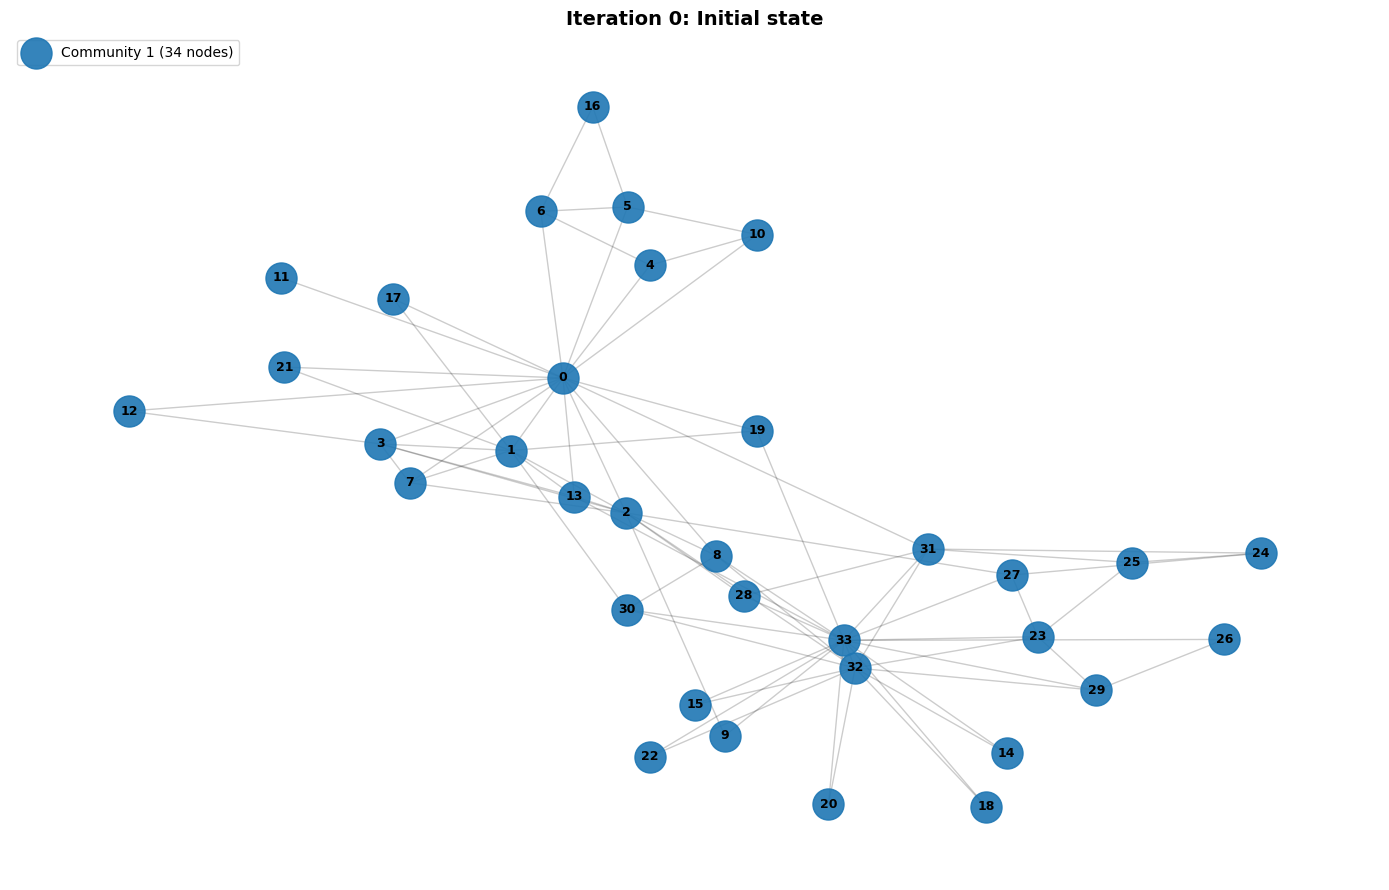

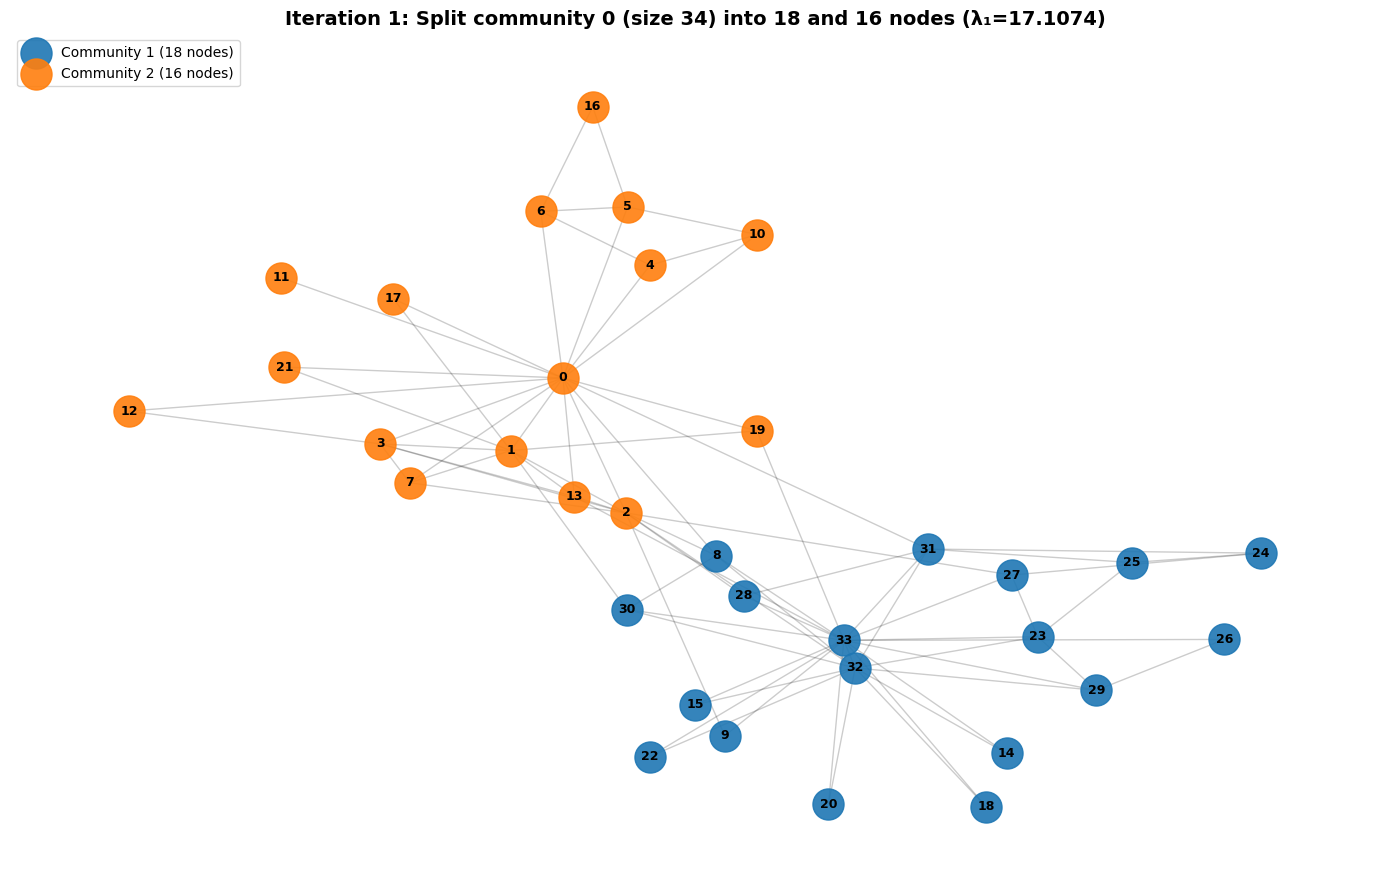


Recursive bisection complete. Found 2 communities in 1 iterations.


In [10]:
# Run recursive bisection
print("Starting recursive spectral bisection...\n")
iterations = recursive_bisection(G, pos)

8 . Visualize Changes in Metrics

At this stage, we generate plots that show how each centrality measure varies across the successive iterations of the community-detection process for every node.


In [11]:
def plot_metric_evolution(iterations, metric_name, title):
    """
    Plot how a specific metric evolves across iterations for all nodes.

    Parameters:
    -----------
    iterations : list of dicts
        Output from recursive_bisection
    metric_name : str
        One of 'degree', 'betweenness', 'closeness', 'clustering'
    title : str
        Plot title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Get all nodes
    nodes = sorted(G.nodes())
    n_iterations = len(iterations)

    # Extract metric values for each node across iterations
    metric_data = {node: [] for node in nodes}
    for iter_data in iterations:
        metrics = iter_data['metrics'][metric_name]
        for node in nodes:
            metric_data[node].append(metrics[node])

    # Plot 1: Line plot for selected nodes (to avoid clutter)
    # Select nodes with highest and lowest initial values, plus some random ones
    initial_values = [(node, metric_data[node][0]) for node in nodes]
    initial_values.sort(key=lambda x: x[1], reverse=True)

    selected_nodes = [initial_values[0][0], initial_values[1][0],  # Top 2
                      initial_values[-1][0], initial_values[-2][0]]  # Bottom 2
    # Add node 0 (Mr. Hi) and node 33 (President) if not already included
    if 0 not in selected_nodes:
        selected_nodes.append(0)
    if 33 not in selected_nodes:
        selected_nodes.append(33)

    for node in selected_nodes:
        ax1.plot(range(n_iterations), metric_data[node], marker='o', label=f'Node {node}')

    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel(title, fontsize=12)
    ax1.set_title(f'{title} - Selected Key Nodes', fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Heatmap showing all nodes
    metric_matrix = np.array([metric_data[node] for node in nodes])
    im = ax2.imshow(metric_matrix, aspect='auto', cmap='viridis', interpolation='nearest')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Node ID', fontsize=12)
    ax2.set_title(f'{title} - All Nodes (Heatmap)', fontsize=13, fontweight='bold')
    ax2.set_yticks(range(0, len(nodes), 5))
    ax2.set_yticklabels(range(0, len(nodes), 5))
    plt.colorbar(im, ax=ax2, label=title)

    plt.tight_layout()
    plt.show()


Visualizing metric evolution across iterations...



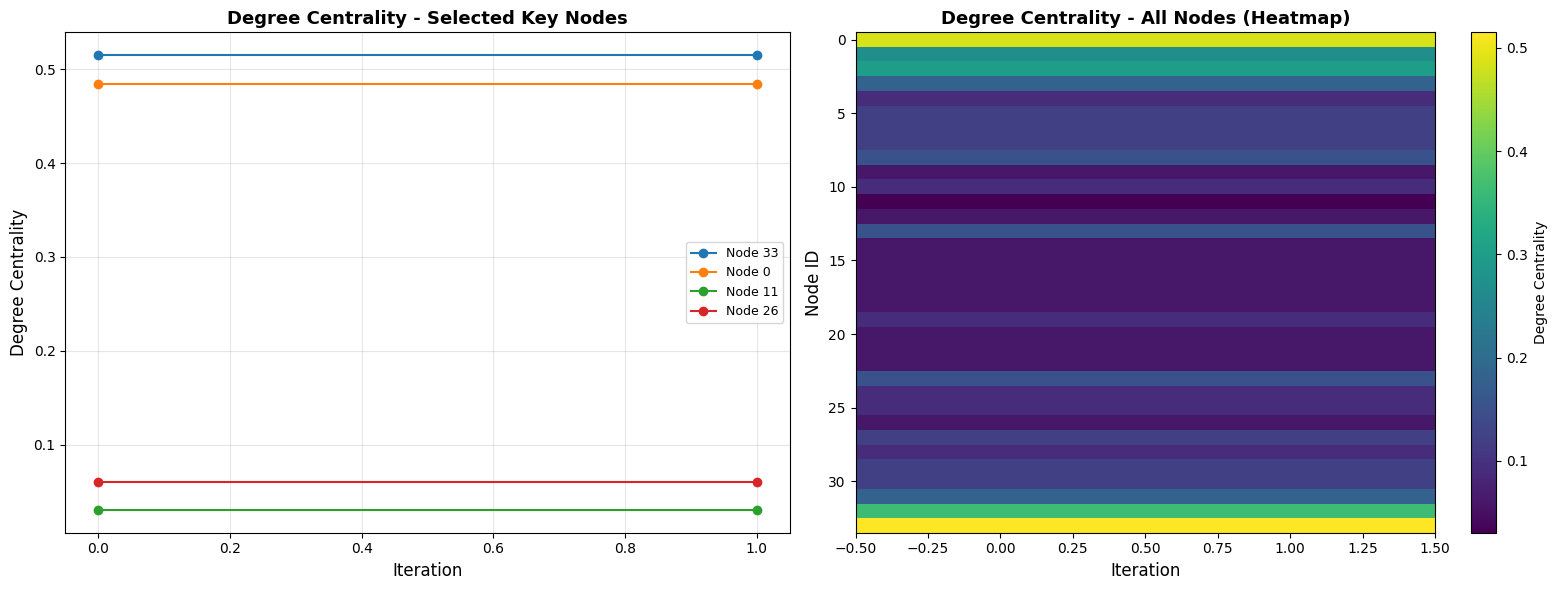

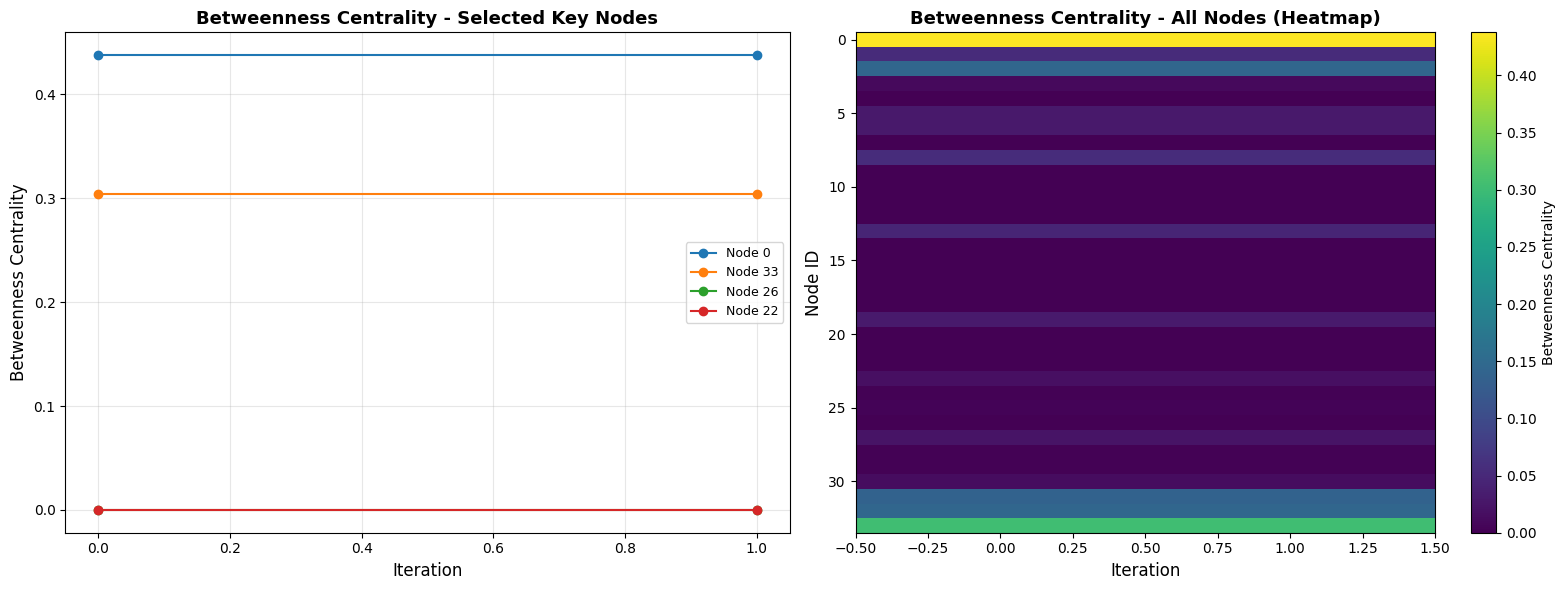

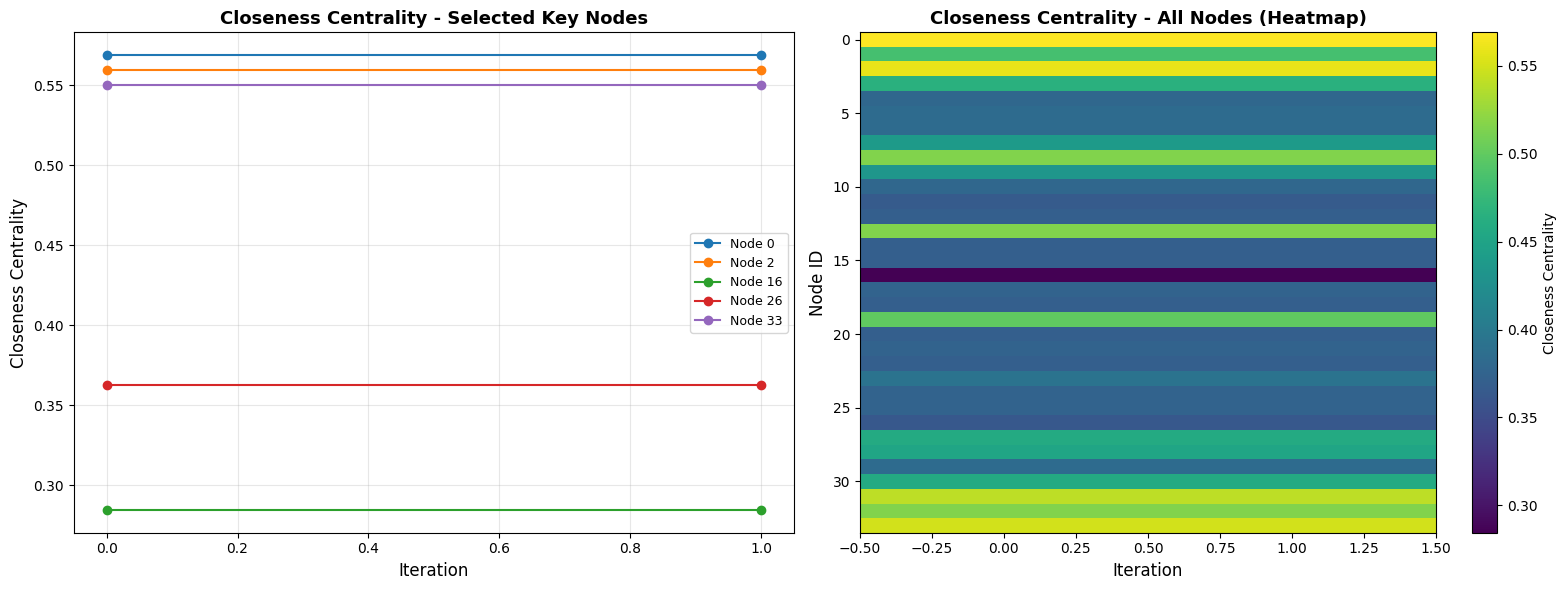

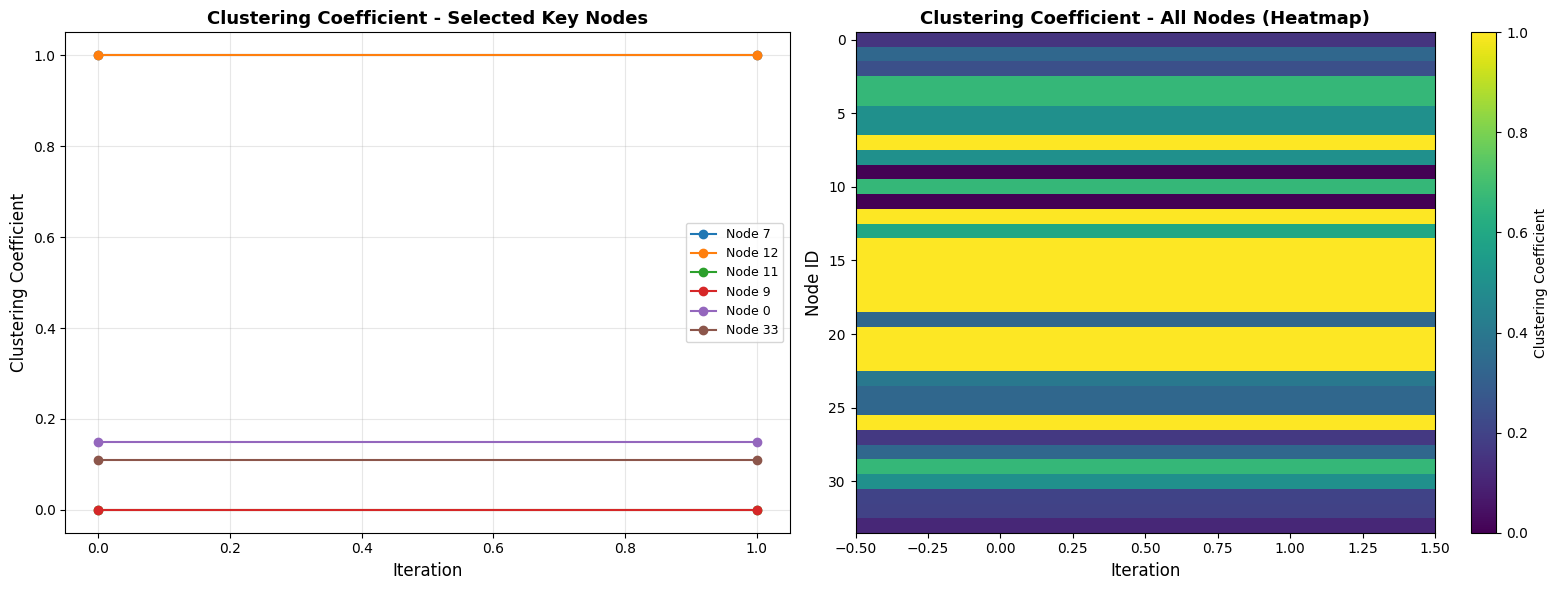

In [12]:
# Plot evolution of each metric
print("\nVisualizing metric evolution across iterations...\n")

plot_metric_evolution(iterations, 'degree', 'Degree Centrality')
plot_metric_evolution(iterations, 'betweenness', 'Betweenness Centrality')
plot_metric_evolution(iterations, 'closeness', 'Closeness Centrality')
plot_metric_evolution(iterations, 'clustering', 'Clustering Coefficient')

9. Summary Statistics

In [13]:
# Print summary of final communities
print("\n" + "="*80)
print("FINAL COMMUNITY STRUCTURE")
print("="*80)

final_communities = iterations[-1]['communities']
for idx, community in enumerate(final_communities):
    print(f"\nCommunity {idx+1}: {len(community)} nodes")
    print(f"  Nodes: {sorted(community)}")

    # Check if Mr. Hi (0) or President (33) are in this community
    if 0 in community:
        print("  Contains: Mr. Hi (node 0)")
    if 33 in community:
        print("  Contains: President (node 33)")


FINAL COMMUNITY STRUCTURE

Community 1: 18 nodes
  Nodes: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  Contains: President (node 33)

Community 2: 16 nodes
  Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
  Contains: Mr. Hi (node 0)


In [14]:
# Analyze top nodes by final metrics
print("\n" + "="*80)
print("TOP NODES BY FINAL CENTRALITY METRICS")
print("="*80)

final_metrics = iterations[-1]['metrics']

for metric_name, metric_title in [('degree', 'Degree Centrality'),
                                   ('betweenness', 'Betweenness Centrality'),
                                   ('closeness', 'Closeness Centrality'),
                                   ('clustering', 'Clustering Coefficient')]:
    print(f"\n{metric_title}:")
    sorted_nodes = sorted(final_metrics[metric_name].items(), key=lambda x: x[1], reverse=True)
    for rank, (node, value) in enumerate(sorted_nodes[:5], 1):
        print(f"  {rank}. Node {node:2d}: {value:.4f}")


TOP NODES BY FINAL CENTRALITY METRICS

Degree Centrality:
  1. Node 33: 0.5152
  2. Node  0: 0.4848
  3. Node 32: 0.3636
  4. Node  2: 0.3030
  5. Node  1: 0.2727

Betweenness Centrality:
  1. Node  0: 0.4376
  2. Node 33: 0.3041
  3. Node 32: 0.1452
  4. Node  2: 0.1437
  5. Node 31: 0.1383

Closeness Centrality:
  1. Node  0: 0.5690
  2. Node  2: 0.5593
  3. Node 33: 0.5500
  4. Node 31: 0.5410
  5. Node  8: 0.5156

Clustering Coefficient:
  1. Node  7: 1.0000
  2. Node 12: 1.0000
  3. Node 14: 1.0000
  4. Node 15: 1.0000
  5. Node 16: 1.0000


from IPython.display import HTML

HTML(r"""
<style>
.smalltext {
    font-size: 11px;
    line-height: 1.35;
    font-family: "DejaVu Sans", sans-serif;
}
</style>

<div class="smalltext">

<h3>Community Structure Interpretation</h3>

Using the spectral modularity method, the Karate Club network was divided
through repeated bipartitioning. A summary of the observations is given below.

<h4>1. Detected Community Organization</h4>

The split is based on the dominant eigenvector of the modularity matrix.
A subdivision is accepted only when the leading eigenvalue satisfies:

$$\lambda_1 > 0$$

This guarantees an increase in modularity.

Historical parallel:
- The well-known fission separated **Mr. Hi (0)** and **the President (33)**.
- The first spectral cut typically places them in opposite groups.

<h4>2. Key Individuals During Splitting</h4>

<b>Degree centrality:</b>  
Stable across splits because it depends only on local neighbors.

<b>Betweenness centrality:</b>  
Highlights bridge nodes. Values drop sharply after splits remove inter-group paths.

<b>Closeness centrality:</b>  
Remains stable inside communities where distances stay short.

<b>Clustering coefficient:</b>  
Measures neighborhood density. Least affected by splitting.

<h4>3. Impact of Community Splitting on Metrics</h4>

<b>Before splitting:</b>  
Betweenness exposes hidden intermediaries.

<b>During splitting:</b>  
Inter-community paths disappear; bridge nodes lose importance.

<b>After splitting:</b>  
Local metrics stay nearly unchanged; global metrics adjust.

<h4>4. Nodes That Stay Influential</h4>

Persistently important nodes:
- Have many neighbors  
- Are embedded in dense regions  
- Act as internal leaders (nodes 0 and 33)

Nodes that lose importance:
- Are early-stage bridges  
- Have high initial betweenness  
- Lose centrality after separation

<h4>5. Mathematical Foundation</h4>

The modularity matrix is defined as:

$$
B = A - \frac{k k^{\top}}{2m}
$$

A community is divided only when:

$$
\lambda_1 > 0
$$

The algorithm automatically identifies how many communities exist, with no preset input.

<h4>Conclusion</h4>

- Spectral modularity reveals meaningful social structure.  
- Node importance depends on local vs global context.  
- Bridge nodes lose influence when communities split.  
- Local measures remain stable; global ones adapt.  
- The Karate Club graph is a classic demonstration of community detection.

<h4>References</h4>

Newman (2006), Zachary (1977), Newman (2010), Fortunato (2010)

</div>
""")References (Rephrased but Complete)

Newman, M. E. J. (2006). Modularity and community structure in networks. PNAS, 103(23), 8577–8582.

Zachary, W. W. (1977). An information-flow model for conflict and fission in small groups. Journal of Anthropological Research, 33(4), 452–473.

Newman, M. E. J. (2010). Networks: An Introduction. Oxford University Press.

Fortunato, S. (2010). Community detection in graphs. Physics Reports, 486(3–5), 75–174.
